## Importing all the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sqlite3 as db

In [ ]:
# Setting the graph style
plt.style.use('ggplot')

## Connecting to SQLite

In [ ]:
con = db.connect('OnlRetailDB')

# Creating a cursor
cur = con.cursor() 

In [ ]:
# Creating a table
cur.execute('create table online_retail (InvoiceNo, StockCode, Description, Quantity, InvoiceDat, UnitPrice, CustomerID, Country)')

In [ ]:
# Loading the data
df = pd.read_excel('/content/Online Retail Data.xlsx')

# Writing records stored in the dataframe(df) to an SQLite Database(SegmentationDB)
df.to_sql('online_retail', if_exists = 'replace', con = con, index = False)

In [ ]:
# Checking if the data is inserted into database
data = cur.execute('SELECT * FROM online_retail')
data = cur.fetchone()
print(data)

('536365', '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, '2010-12-01 08:26:00', 2.55, 17850.0, 'United Kingdom')


In [ ]:
# Checking if all the rows are successfully inserted into the database
total_rows = cur.execute('SELECT COUNT(*) FROM online_retail')
total_rows = cur.fetchone()
total_rows

(541909,)

## Task 1 - Data Understanding

In [124]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- 8 variables are there in the dataset and has both numerical and categorical variables.

In [ ]:
# Dimension of the dataset
df.shape

(541909, 8)

- Number of rows = 541909
- Number of columns = 8

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- CustomerID has incorrect datatype. It should be integer. We wont convert it into object even though it has categorical characteristic as it is to be fed to the model.

- We will convert it after treating the missing values.

A. Statistical Exploration

In [ ]:
# Statistical Summary for Numerical Variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Observations:
- CustomerID is as good as categorical variable. 
- CustomerID has missing values. We need to remove them in the data cleaning step. 

In [ ]:
# Statistical Summary for Categorical Variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


Observations:
1. Total transactions = 25900
2. Total products = 4070

- White hanging heart T-Light Holder is the most popular product.
- United Kingdom has the highest amount of purchases.

B. Elimination of redundant variables

In [ ]:
# Removing invalid and cancelled records 
clean_transaction_data = pd.read_sql('''SELECT * 
                       FROM online_retail WHERE InvoiceNo NOT LIKE 'C%'
          AND CustomerID IS NOT NULL 
          AND UnitPrice > 0
          AND Quantity > 0''', con)
clean_transaction_data.to_sql("clean_data", con)
clean_transaction_data.shape

(397884, 8)

- All the cancelled transantions, Null values in CustomerID and Descriptions and values which are zero and less than zeroes in UnitPrice and Quantity will be removed using this query. 

In [ ]:
# Checking for duplicated data
clean_transaction_data.duplicated().sum()

5192

In [ ]:
# Removing duplicated records
clean_transaction_data = pd.read_sql('''SELECT DISTINCT InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country 
                       FROM clean_data''', con)
clean_transaction_data.to_sql("clean_transaction_data", con)

In [ ]:
clean_transaction_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Checking for duplicated data 
clean_transaction_data.duplicated().sum()

0

- All the duplicated data has been removed from the dataset.

In [ ]:
clean_transaction_data.shape

(392692, 8)

- 149,217 redundant records has been deleted from the dataset. Hence, we can conclude that the data is clean.

C. Management of missing values

In [ ]:
# Checking for missing values
clean_transaction_data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- There are no missing values.

D. Suitable Transformation of variables



In [ ]:
clean_transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      392692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.0+ MB


- Change the datatype of InvoiceDate from object to datetime.
- Change the datatype of CustomerID from float to int.

In [ ]:
# Creating copy for the cleaned data for data manipulation
new_df = clean_transaction_data.copy()

In [ ]:
# Correcting the incorrect data types
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'])
new_df['CustomerID'] = new_df['CustomerID'].astype(int)

In [ ]:
# Checking the corrected data types
new_df[['InvoiceDate', 'CustomerID']].dtypes

InvoiceDate    datetime64[ns]
CustomerID              int64
dtype: object

In [ ]:
# Create a new column TotalPrice
new_df['TotalPrice'] = new_df['UnitPrice'] * new_df['Quantity']
new_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


E. Distribution Analysis

In [ ]:
# Distribution of UnitPrice
new_df['UnitPrice'].describe()

count    392692.000000
mean          3.125914
std          22.241836
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

- The average price for one quantity i.e., the average price paid by most of the customers for one quantity is 3.12.
- Minimum amount paid for a quantity is 0.01 and maximum amount paid for a quantity is 8142.75

In [ ]:
# Distribution of data based on Country
new_df['Country'].value_counts(normalize=True)

United Kingdom          0.889254
Germany                 0.022982
France                  0.021202
EIRE                    0.018401
Spain                   0.006313
Netherlands             0.006007
Belgium                 0.005172
Switzerland             0.004688
Portugal                0.003700
Australia               0.003007
Norway                  0.002727
Italy                   0.001930
Channel Islands         0.001902
Finland                 0.001744
Cyprus                  0.001536
Sweden                  0.001146
Austria                 0.001014
Denmark                 0.000968
Poland                  0.000840
Japan                   0.000817
Israel                  0.000624
Unspecified             0.000614
Singapore               0.000565
Iceland                 0.000463
USA                     0.000456
Canada                  0.000385
Greece                  0.000369
Malta                   0.000285
United Arab Emirates    0.000173
European Community      0.000153
RSA       

- Customers from United Kingdoms has made the maximum purchases i.e., approx 89% more compared to other countries. 
- Other countries together contributes only around 11% of the total.

In [ ]:
# Checking how many products are there after cleaning
new_df['Description'].nunique()

3877

In [ ]:
# Top 10 items sold
new_df['Description'].value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1713
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1389
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
Name: Description, dtype: int64

In [ ]:
# Checking the total number of customers
new_df['CustomerID'].nunique()

4338

Total number of customers = 4338

F. Correlation Analysis

In [ ]:
corr = new_df[['UnitPrice', 'Quantity', 'TotalPrice']].corr()

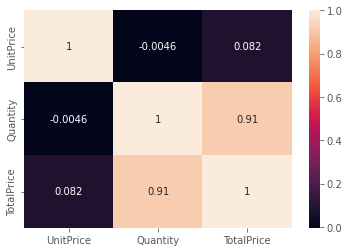

In [ ]:
sns.heatmap(corr, annot=True)

G. Data Visualization

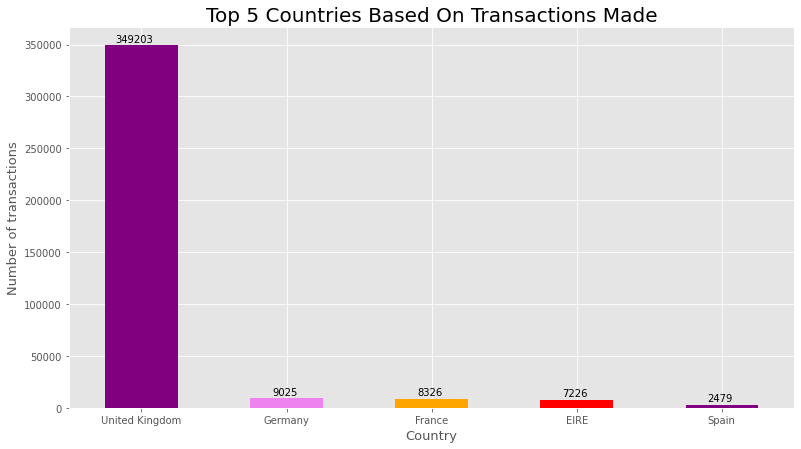

In [ ]:
# Top 5 countries based on number of transactions
new_df['Country'].value_counts().head(5).plot.bar(color=['purple', 'violet', 'orange', 'red'], figsize=(13,7))
plt.title('Top 5 Countries Based On Transactions Made', fontsize = 20)
plt.ylabel('Number of transactions', fontsize = 13)
plt.xlabel('Country', fontsize = 13)

plt.text(x=-0.18, y=352000, s=new_df['Country'].value_counts()[0])
plt.text(x=0.9, y=12000,s=new_df['Country'].value_counts()[1])
plt.text(x=1.9, y=12000,s=new_df['Country'].value_counts()[2])
plt.text(x=2.9, y=11000,s=new_df['Country'].value_counts()[3])
plt.text(x=3.9, y=6000,s=new_df['Country'].value_counts()[4])

plt.xticks(rotation = 0)
plt.show()

- United Kingdom, Germany, France, EIRE, and Spain are the top 5 countries with more number of transactions.

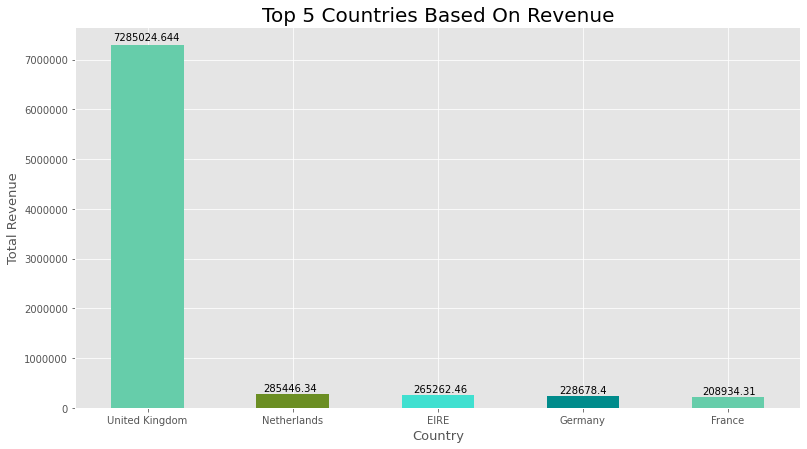

In [ ]:
Revenue = new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False).head(5)
plt.ticklabel_format(style='plain')
Revenue.plot.bar(color=['mediumaquamarine', 'olivedrab', 'turquoise', 'darkcyan'], figsize=(13,7))

plt.title('Top 5 Countries Based On Revenue', fontsize = 20)
plt.ylabel('Total Revenue', fontsize = 13)
plt.xlabel('Country', fontsize = 13)

plt.text(x=-0.24, y=7390000, s=new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)[0])
plt.text(x=0.8, y=340000, s=new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)[1])
plt.text(x=1.83, y=310000, s=new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)[2])
plt.text(x=2.84, y=299999, s=new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)[3])
plt.text(x=3.82, y=280000, s=new_df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)[4])

plt.xticks(rotation = 0)
plt.show()

- United Kingdom, Netherlands, EIRE, Germany, and France generated more revenue compared to other countries.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


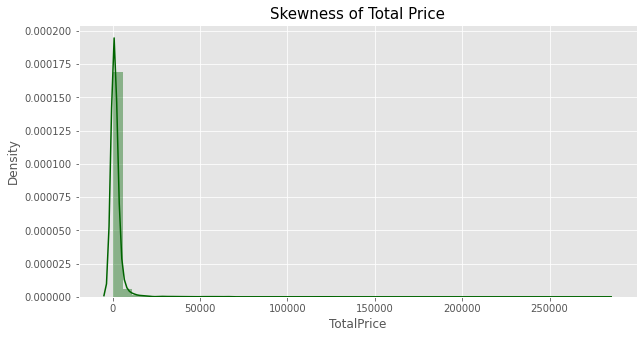

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Skewness of Total Price', fontsize= 15)
sns.distplot(new_df.groupby(['CustomerID'])['TotalPrice'].sum(), kde=True, color = 'darkgreen');

- The plot shows that total price is right skewed. Which means there are some heavy spenders in the dataset.

## Task 2 - Performing RFM Segmentation

Calculating RFM values

In [ ]:
# Extract year, month, and day
import datetime as dt
new_df['New_InvoiceDate'] = new_df['InvoiceDate'].apply(lambda x : dt.datetime(x.year, x.month, x.day))
new_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,New_InvoiceDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


In [ ]:
# Checking the time period
print('Min : {}'.format(min(new_df['New_InvoiceDate'])))
print('Max : {}'.format(max(new_df['New_InvoiceDate'])))   

Min : 2010-12-01 00:00:00
Max : 2011-12-09 00:00:00


- Last day present in the dataset is 9th December 2011. So, we set december 10th as our pining date.

In [ ]:
# Pining the last date
pin_date = max(new_df['New_InvoiceDate']) + dt.timedelta(1)

In [ ]:
# Calculating the RFM values
rfm = new_df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (pin_date - date.max()).days,
                                        'InvoiceNo' : lambda invoice : invoice.nunique(),
                                        'TotalPrice': lambda price: price.sum()})

# Renaming Columns
rfm.columns=['Recency', 'Frequency', 'Monetary']

In [ ]:
len(new_df.groupby('InvoiceNo')['CustomerID'].count().to_list())

18532

In [ ]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


In [ ]:
rfm.shape

(4338, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

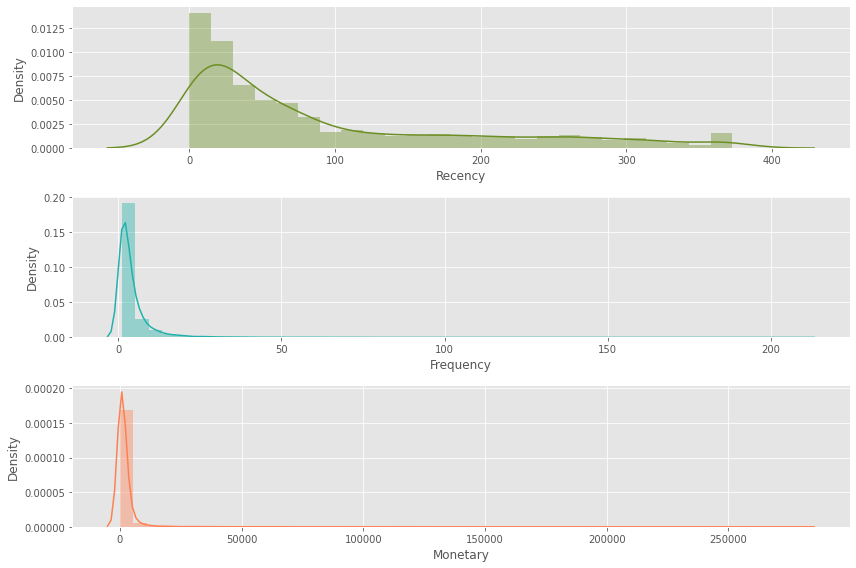

In [ ]:
# Checking the distribution of recency, frequency, and monetary values
plt.figure(figsize=(12,8))

# Distribution of Recency values
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'], color = 'olivedrab')

# Distribution of Frequency values
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'], color = 'lightseagreen')

# Distribution of Monetary values
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'], color = 'coral')

plt.tight_layout()

In [ ]:
# Calculating RFM scores
rfm['Recency_Score'] = pd.qcut(rfm['Recency'], q = 5, labels = [5, 4, 3, 2, 1])
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q = 5, labels = [1, 2, 3, 4, 5])
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], q = 5, labels = [1, 2, 3, 4, 5])

rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
CustomerID,,,,,,
12346,325,1,77183.60,1,1,5
12347,2,7,4310.00,5,5,5
12348,75,4,1797.24,2,4,4
12349,18,1,1757.55,4,1,4
12350,310,1,334.40,1,1,2


In [ ]:
# Calculation of RFM Score
rfm['RFM_Comb'] = rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str)+ rfm['Monetary_Score'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Comb
CustomerID,,,,,,,
12346,325,1,77183.60,1,1,5,115
12347,2,7,4310.00,5,5,5,555
12348,75,4,1797.24,2,4,4,244
12349,18,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4338.0,92.059474,100.012264,0.00,17.0000,50.00,141.7500,373.00
Frequency,4338.0,4.272015,7.697998,1.00,1.0000,2.00,5.0000,209.00
Monetary,4338.0,2048.688081,8985.230220,3.75,306.4825,668.57,1660.5975,280206.02


In [ ]:
def Cust_Segment(rfm):
    if ((rfm['Recency_Score'] >= 4) and (rfm['Frequency_Score'] >= 4) 
        and (rfm['Monetary_Score'] >= 4)):
        return 'Best Customers'
    elif ((rfm['Recency_Score'] >= 3) and (rfm['Frequency_Score'] >= 3)
          and (rfm['Monetary_Score'] >= 3)):
        return 'Loyal'
    elif ((rfm['Recency_Score'] >= 3) and (rfm['Frequency_Score'] >= 1)
          and (rfm['Monetary_Score'] >= 2)):
        return 'Potential Loyalist'
    elif ((rfm['Recency_Score'] >= 3) and (rfm['Frequency_Score'] >= 1)
          and (rfm['Monetary_Score'] >= 1)):
        return 'Promising'
    elif ((rfm['Recency_Score'] >= 2) and (rfm['Frequency_Score'] >= 2)
          and (rfm['Monetary_Score'] >= 2)):
        return 'Customers Needing Attention'
    elif ((rfm['Recency_Score'] >= 1) and (rfm['Frequency_Score'] >= 2)
          and (rfm['Monetary_Score'] >= 2)):
        return 'At Risk'
    elif ((rfm['Recency_Score'] >= 1) and (rfm['Frequency_Score'] >= 1)
          and (rfm['Monetary_Score'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

rfm['Customer_Segment'] = rfm.apply(Cust_Segment, axis=1)
rfm.sample(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Comb,Customer_Segment
CustomerID,,,,,,,,
12565,288,1,145.92,1,1,1,111,Lost
13324,36,10,7121.95,3,5,5,355,Loyal
18024,152,2,389.78,2,3,2,232,Customers Needing Attention
13984,26,5,920.51,4,4,3,443,Loyal
17905,71,4,798.99,3,4,3,343,Loyal
15853,51,1,110.80,3,2,1,321,Promising
16040,65,3,1313.55,3,4,4,344,Loyal
14953,25,1,285.67,4,1,2,412,Potential Loyalist
15136,2,4,1286.70,5,4,4,544,Best Customers


In [ ]:
# Calculating total customers in each segment
Cust_agg = rfm.groupby('Customer_Segment').agg({'RFM_Comb' : 'count'}).reset_index()
Cust_agg 

,Customer_Segment,RFM_Comb
0,At Risk,322
1,Best Customers,948
2,Customers Needing Attention,565
3,Hibernating,299
4,Lost,541
5,Loyal,766
6,Potential Loyalist,570
7,Promising,327


In [ ]:
pip install squarify

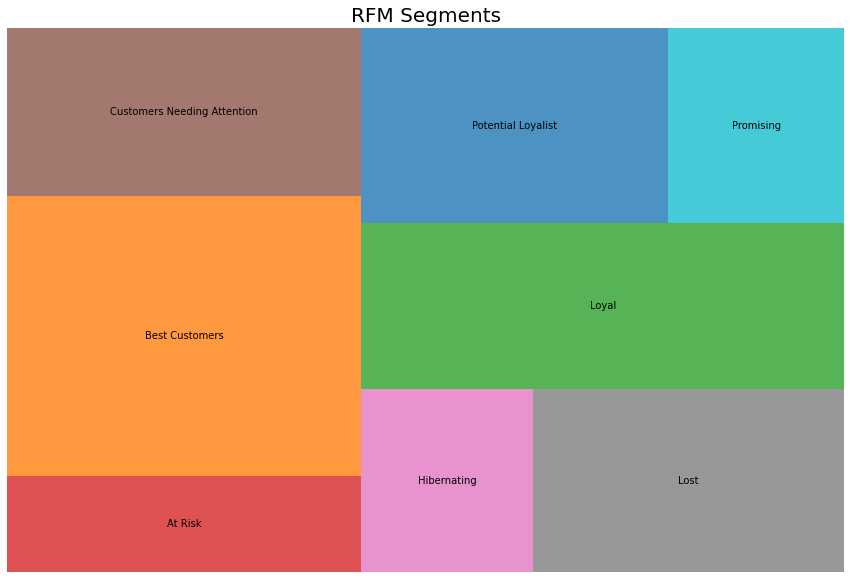

In [ ]:
import squarify
fig, ax = plt.subplots(1, figsize = (15,10))
plt.title('RFM Segments', fontsize=20)
squarify.plot(sizes=Cust_agg['RFM_Comb'], 
              label=Cust_agg['Customer_Segment'], 
              alpha=.8,
              color=['tab:red', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray',
                     'tab:green', 'tab:blue', 'tab:cyan']
             )
plt.axis('off')
plt.show()

## Task 3 - Customer Segmentation with K-Means

In [ ]:
final_df = rfm.drop(columns = ['Recency_Score', 'Frequency_Score', 'Monetary_Score', 'Customer_Segment', 'RFM_Comb'])

In [ ]:
final_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


In [ ]:
final_df.shape

(4338, 3)

In [ ]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
mmscale = MinMaxScaler()
data_normalized = mmscale.fit_transform(final_df)
data_normalized 

array([[8.71313673e-01, 0.00000000e+00, 2.75443343e-01],
       [5.36193029e-03, 2.88461538e-02, 1.53683623e-02],
       [2.01072386e-01, 1.44230769e-02, 6.40069761e-03],
       ...,
       [1.87667560e-02, 4.80769231e-03, 6.22050635e-04],
       [8.04289544e-03, 7.21153846e-02, 7.28680749e-03],
       [1.12600536e-01, 9.61538462e-03, 6.54359438e-03]])

CLUSTERING THE DATA USING k-MEANS

In [ ]:
n_clusters = [3, 5, 7, 9]

for k in n_clusters:
    cluster = KMeans (n_clusters=k, random_state=10)
    predict = cluster.fit_predict(data_normalized)  
    score = silhouette_score(data_normalized, predict, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(k, score))

For n_clusters = 3, silhouette score is 0.6441395494678179)
For n_clusters = 5, silhouette score is 0.5535262048155307)
For n_clusters = 7, silhouette score is 0.5436165161701767)
For n_clusters = 9, silhouette score is 0.49113832932198964)


- In order to remove any type of ambiguity in making clusters we have chosen a list of odd number of clusters.
- Optimal number of cluster = 5, as silhouette score is maximum for n_clusters=5

In [ ]:
# Building a K-means model for K=3
model = KMeans(n_clusters=3, random_state=10)

# Fit the model
model.fit(data_normalized)

KMeans(n_clusters=3, random_state=10)

In [ ]:
# Retrieving the clusters
data_output = final_df.copy(deep=True)

# Add a column 'Cluster' in the data giving cluster number corresponding to each observation
data_output['Cluster'] = model.labels_
data_output.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,77183.60,2
12347,2,7,4310.00,1
12348,75,4,1797.24,1
12349,18,1,1757.55,1
12350,310,1,334.40,2


In [ ]:
data_output['Cluster_Name']=data_output['Cluster'].map({0 : 'Cluster_1',
                                                        1 : 'Cluster_2',
                                                        2 : 'Cluster_3'})
data_output.drop('Cluster',axis=1,inplace=True)

In [ ]:
data_output.head()

,Recency,Frequency,Monetary,Cluster_Name
CustomerID,,,,
12346,325,1,77183.60,Cluster_3
12347,2,7,4310.00,Cluster_2
12348,75,4,1797.24,Cluster_2
12349,18,1,1757.55,Cluster_2
12350,310,1,334.40,Cluster_3


In [ ]:
# 'return_counts=True' gives the number of observation in each cluster
np.unique(model.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 814, 2898,  626]))

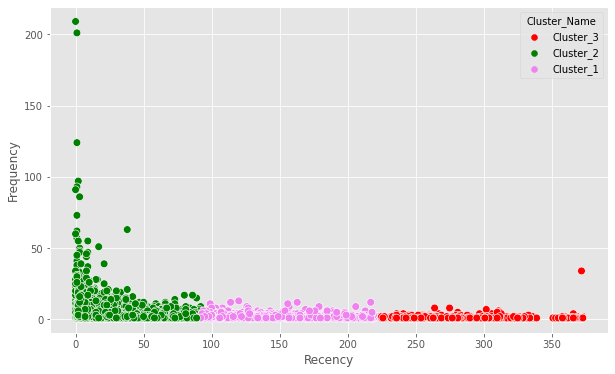

In [ ]:
# Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Recency', y = 'Frequency', hue = "Cluster_Name",  
                 palette = ['red', 'green', 'violet'], 
                legend ='full', data = data_output, s = 60)
plt.xlabel('Recency')
plt.ylabel('Frequency') 
plt.show()

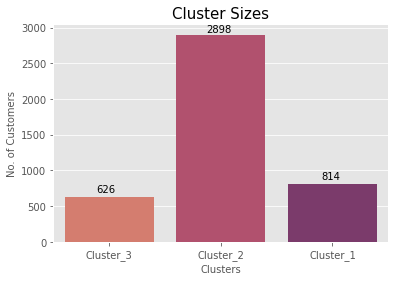

In [ ]:
# Countplot to visualize the cluster sizes
sns.countplot(data=data_output, x='Cluster_Name', palette='flare')

plt.title('Cluster Sizes', fontsize=15)
plt.xlabel('Clusters', fontsize=10)
plt.ylabel('No. of Customers', fontsize=10)

plt.text(x = 1.9, y = 870, s=np.unique(model.labels_, return_counts=True)[1][0])
plt.text(x = 0.87, y = 2930, s=np.unique(model.labels_, return_counts=True)[1][1])
plt.text(x = -0.12, y = 700, s=np.unique(model.labels_, return_counts=True)[1][2])

plt.show()

CONCLUSION:

- It can be seen in the scatterplot that the customers in cluster_2 have made recent purchases. They are profitable and loyal customers. From countplot we can see that there are 2898 customers in cluster_2.

- Cluster_1 has customers who hasn't made recent purchases i.e., it's been over 3 months. But, they can be considered as loyal customers who are in hibernating mode. These customers needs attention for the company to not lose potentially profitable customers. This cluster has 814 customers.

- 626 customers are there in cluster_3, they can be considered as occasional buyers.